# Recurrent Neural Network Simulating a Dynamic System

In [77]:
! pip3 install sympy matplotlib

## 1. Definition of a Dynamic Process

Classes DynamicModel and DynamicProcess are defined file DynamicSystem.py. DynamicModel holds a description of a dynamic system in a symbolic form and as a differential equation. DynamicProcess helps to model a response (time series) of such model for a random input.   

In [86]:
from sympy.abc import s, t, y, x, y, z

In [87]:
from DynamicSystem import DynamicModel, DynamicProcess

### 1.1 Symbolic Definition of a Chosen System

In [88]:
G = 5*(s+1)/((s+3)*(s+2))
dynamic_model = DynamicModel(G)

In [89]:
dynamic_process = DynamicProcess(dynamic_model, 100)
dynamic_process.model

(5*s + 5)/((s + 2)*(s + 3))

### 1.2. Example of system responses for different inputs 

In [90]:
import matplotlib.pyplot as plt
import numpy as np

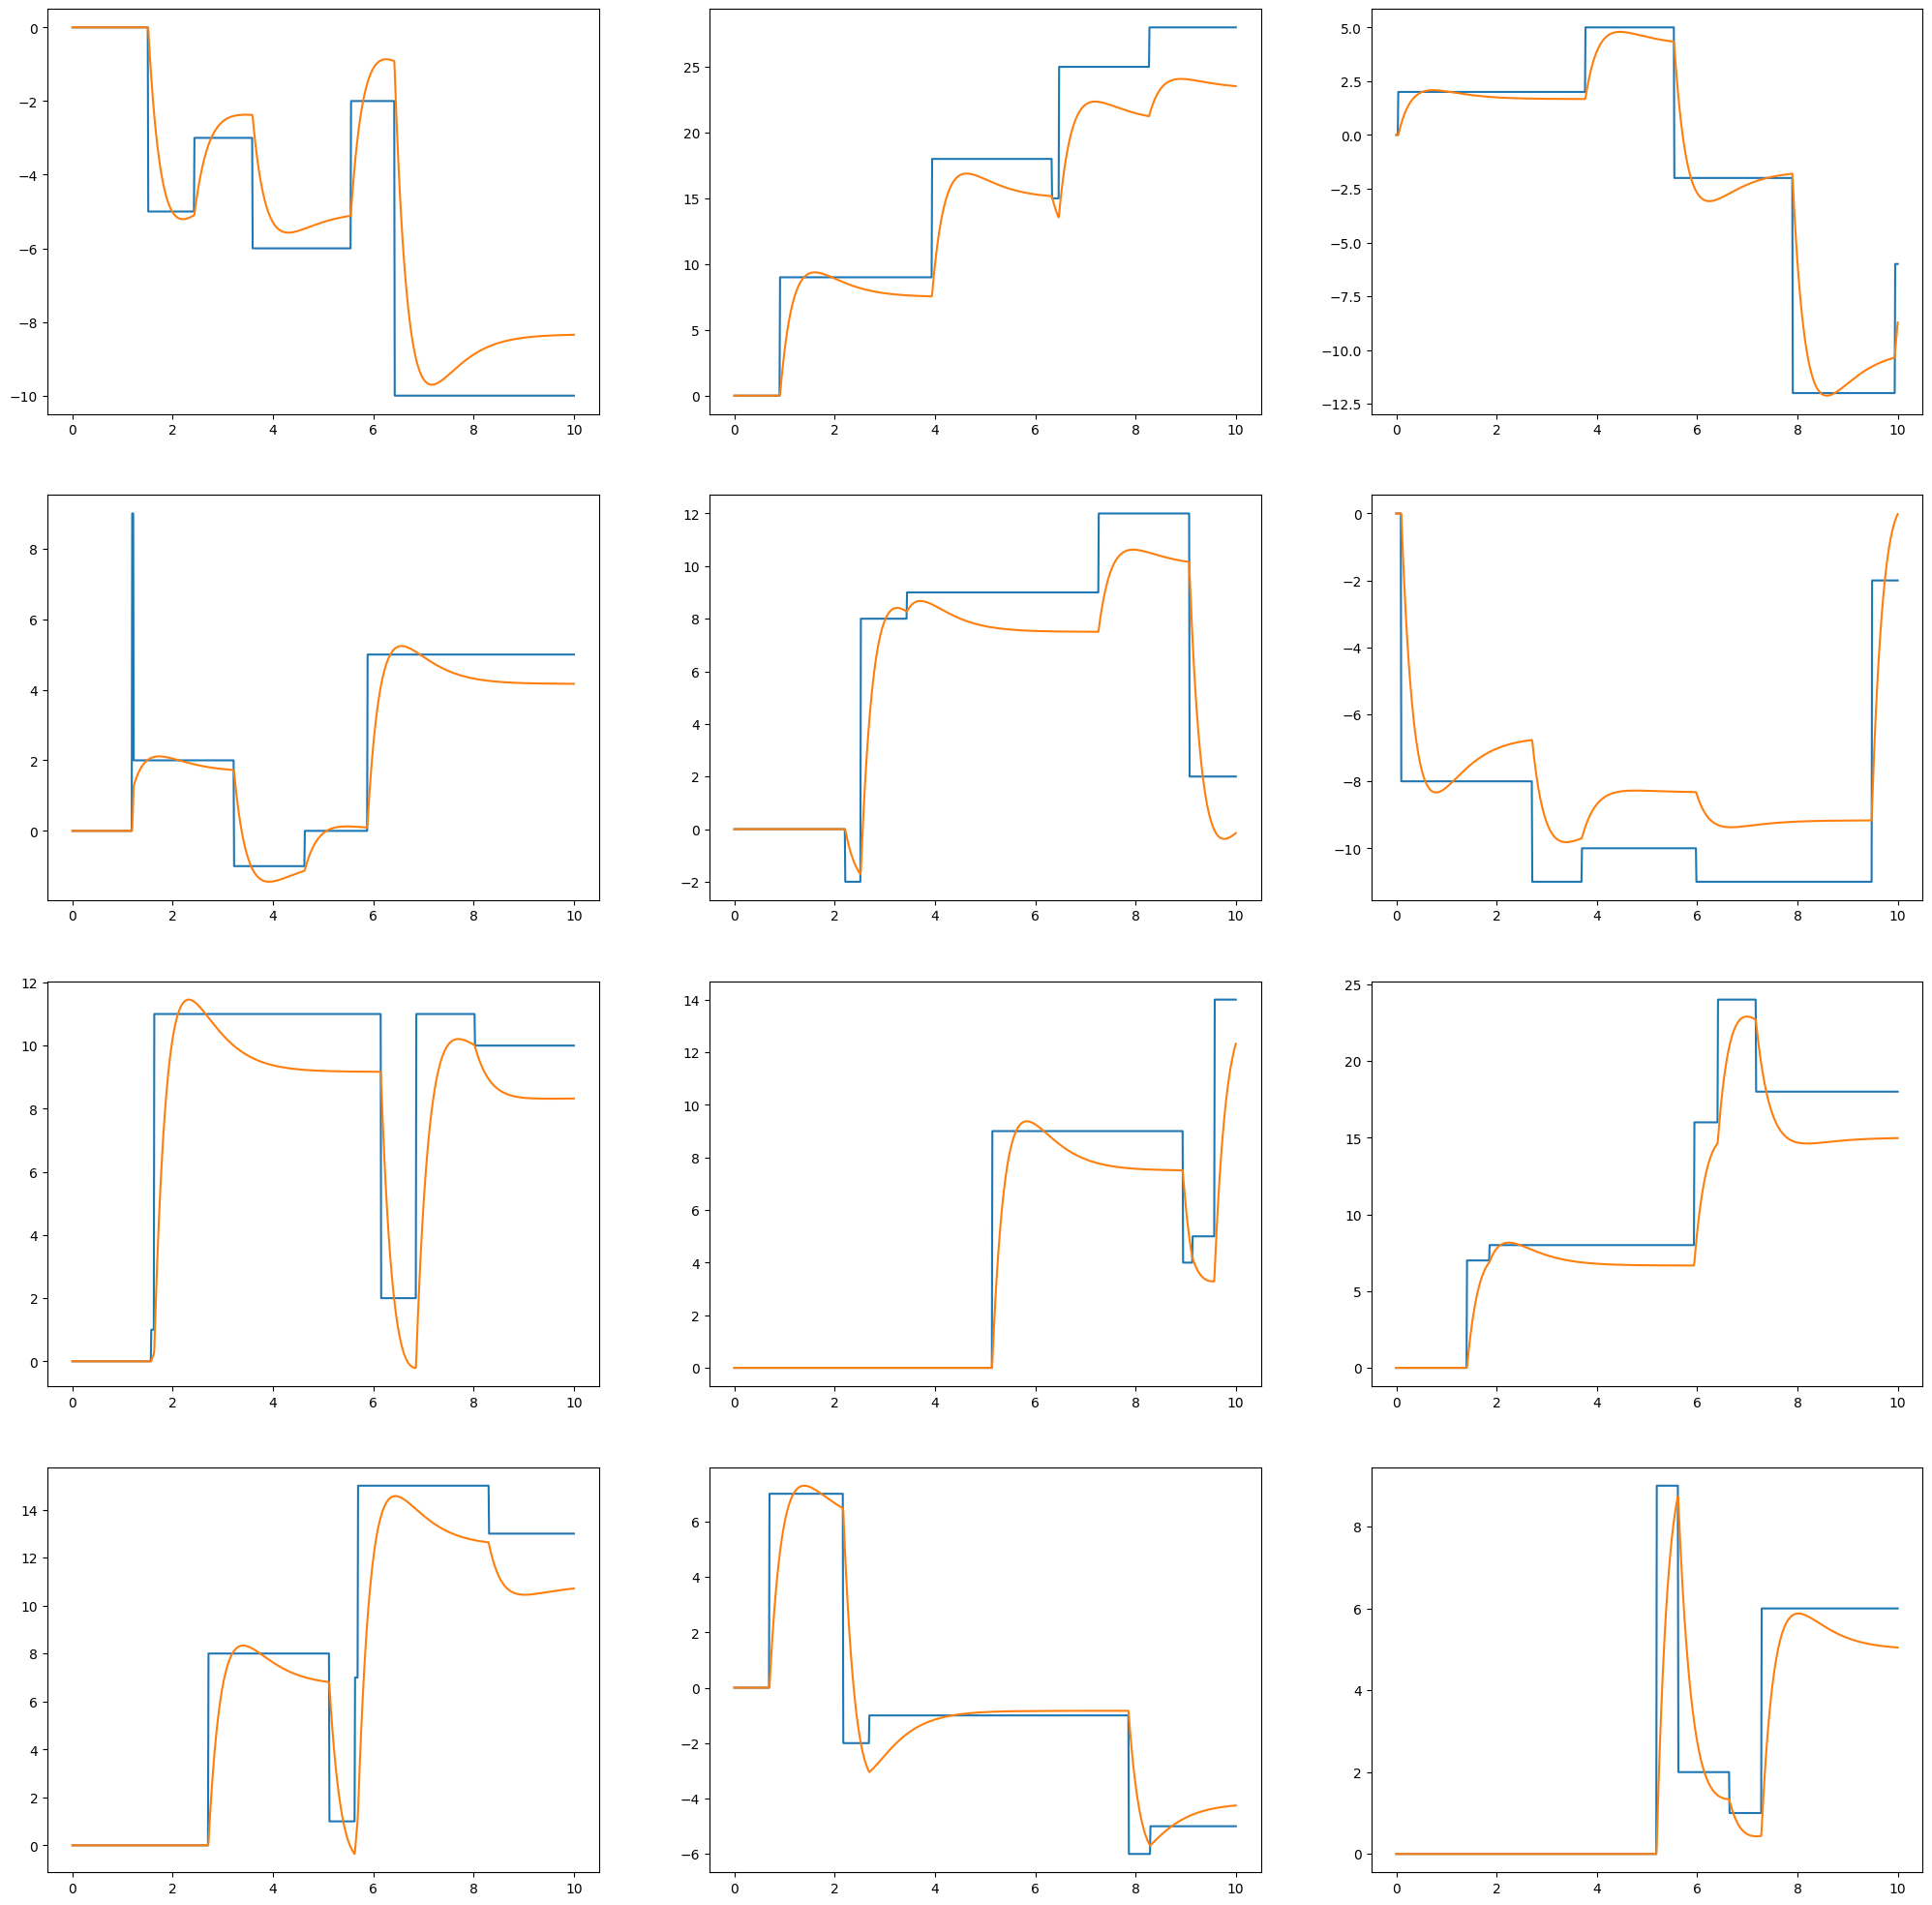

In [284]:
plt.figure(figsize=(25,25))
for i in range(12):
    t, u, y = dynamic_process.generate_time_series(10, 1000, new_inputs=True)
    plt.subplot(4,3,i+1)
    plt.plot(t, u)
    plt.plot(t, y)
plt.show()

## 2. Generate and Save Dataset

In [ ]:
import pandas as pd
import os
import pymongo

In [ ]:
# Set up pymongo client
client = pymongo.MongoClient('localhost', 27017)
db = client.DynamicSystem
time_series_collection = db.time_series 

In [ ]:
start = 20
stop = 40
for i in range(start, stop):
    t, u, y = dynamic_process.generate_time_series(10, 1000, new_inputs=True)
    data = {'t':t, 'u':u, 'y':y}
    df = pd.DataFrame(data)
    
    # Save to csv
    df.to_csv(f'dataset/{i}.csv', index=False)
    
    # Save to pymongo
    # time_series_collection.insert_one(df.to_json())

### 2.1. Prepare Dataset

In [91]:
import tensorflow as tf
from tensorflow import keras

#### 2.1.1. Import files

#### 2.1.2. Normalization and split

In [92]:
dataset_path = 'dataset/'
dataset_files = [ f'{dataset_path}/{file}' for file in os.listdir(dataset_path) if 'csv' in file]

val_samples = round(len(dataset_files) * 0.2)
train_ds = dataset_files[:-val_samples]
val_ds = dataset_files[-val_samples:]

In [ ]:
def normalize_dataset(files):
    
    # Concatante data from every file 
    
    # Calculate normalized values
    
    # Save them as additional columns
    
    
    pass

### 2.1. BatchBuilder

In [292]:
class TimeSeriesBatchBuilder(keras.utils.Sequence):
    """_summary_
    Helps to iterate over the dataset
    Args:
        keras (_type_): _description_
    """

    def __init__(self, dataset_files, window_size):
        self.dataset_files = dataset_files
        self.window_size = window_size
        self.file_len = len(pd.read_csv(self.dataset_files[0]))
        self.batch_size = self.file_len / self.window_size
        self.mean = 0 
        self.std = 0
    
    def __len__(self):
        return len(self.dataset_files)

    def __getitem__(self, idx):
        """Returns tuple (input, output) that corresponds to batch idx"""
        
        i = idx * self.batch_size
        batch_file = pd.read_csv(self.dataset_files[idx])
        
        x, y = [], []
        end = self.file_len - self.window_size
        for i in range(self.window_size, end):
            x_temp = np.concatenate((batch_file['u'][i:i+self.window_size].values, batch_file['y'][i:i+self.window_size].values))
            x.append(x_temp)
            y.append(batch_file['y'][i+self.window_size])
        
        return np.array(x, dtype=np.float32), np.array(y, dtype=np.float32)

In [320]:
WINDOW_SIZE = 30
train_gen = TimeSeriesBatchBuilder(train_ds, window_size=WINDOW_SIZE)
val_gen = TimeSeriesBatchBuilder(val_ds, window_size=WINDOW_SIZE)

In [294]:
x, y = train_gen.__getitem__(0)

In [295]:
x[300]

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 9.        , 9.        , 9.        ,
       9.        , 9.        , 9.        , 9.        , 9.        ,
       0.8377991 , 0.8376999 , 0.8376007 , 0.8376007 , 0.8375015 ,
       0.83740234, 0.83730316, 0.83719635, 0.83719635, 0.83709717,
       0.836998  , 0.8368988 , 0.8368988 , 0.8367996 , 0.83670044,
       0.83670044, 0.83660126, 0.8365021 , 0.8365021 , 0.8364029 ,
       0.8364029 , 0.8363037 , 0.9761963 , 1.3630981 , 1.7346954 ,
       2.0915985 , 2.4341984 , 2.7630978 , 3.078598  , 3.381401  ],
      dtype=float32)

In [228]:
y[0]

0.50499725

### Prepare Baseline model for benchmarking

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

## 3. Prepare Data

## 4. Recurrent Neural Network

### 4.1. Definitions of models

In [299]:
import tensorflow as tf
from keras.layers import Dropout
from keras.layers import Dense, LSTM, Input, Conv1D
from keras.optimizers import Adam
from keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from keras.models import Sequential

In [300]:
def base_model(input_shape):
  pass


def dnn_model(input_shape, layers, units, dropout, loss, optimizer, metrics):
  
  model = Sequential()
  model.add(Input(shape=input_shape))
  for _ in range(layers):
    model.add(Dense(units=units))
    model.add(Dropout(rate=dropout))
  model.add(Dense(units=1))
  
  model.compile(loss=loss,
                optimizer=optimizer,
                metrics=metrics)
  model.summary()
  
  return model


def cnn_model(input_shape, layers, units, dropout, loss, optimizer, metrics):
  CONV_WIDTH = 3
  
  model = Sequential()
  model.add(Input(shape=input_shape))
  for _ in range(layers):
    model.add(Conv1D(filters=units, activation='relu', kernel_size=(CONV_WIDTH)))
    model.add(Dropout(rate=dropout))
  model.add(Dense(units=1))
  
  model.compile(loss=loss,
                optimizer=optimizer,
                metrics=metrics)
  model.summary()
  
  return model


def rnn_model(input_shape, layers, units, dropout, loss, optimizer, metrics):

  model = Sequential()
  model.add(Input(shape=input_shape))
  for _ in range(layers-1):
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(rate=dropout))
    
  model.add(LSTM(units=units, return_sequences=False))
  model.add(Dropout(rate=dropout))
  model.add(Dense(units=1))
  
  model.compile(loss=loss,
                optimizer=optimizer,
                metrics=metrics)
  model.summary()
    
  return model 

In [331]:
learning_rate = 0.001

# Add patiance

params = {
    'input_shape': (WINDOW_SIZE*2, 1),
    'layers': 4,
    'units': 90,
    'dropout': 0.2,
	'loss': 'mean_squared_error',
	'optimizer': 'adam',
    'metrics': [RootMeanSquaredError(), MeanAbsoluteError()],
}

#### 4.1.1. List of defined and compiled models

In [332]:
models = {
    'dnn':dnn_model(**params),
    'cnn':cnn_model(**params),
    'rnn':rnn_model(**params)
}

TypeError: dnn_model() got an unexpected keyword argument 'metrics'

In [323]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [324]:
history = models['rnn'].fit(train_gen, epochs=15, validation_data=val_gen)

Epoch 1/20
32/32 [==============================] - 57s 2s/step - loss: 23.7751 - root_mean_squared_error: 4.8760 - mean_absolute_error: 3.1762 - val_loss: 21.2231 - val_root_mean_squared_error: 4.6068 - val_mean_absolute_error: 3.4966
Epoch 2/20
32/32 [==============================] - 55s 2s/step - loss: 10.5859 - root_mean_squared_error: 3.2536 - mean_absolute_error: 1.6410 - val_loss: 8.7849 - val_root_mean_squared_error: 2.9639 - val_mean_absolute_error: 1.8851
Epoch 3/20
32/32 [==============================] - 78s 2s/step - loss: 6.3116 - root_mean_squared_error: 2.5123 - mean_absolute_error: 1.1455 - val_loss: 5.2425 - val_root_mean_squared_error: 2.2897 - val_mean_absolute_error: 1.3263
Epoch 4/20
32/32 [==============================] - 68s 2s/step - loss: 4.4609 - root_mean_squared_error: 2.1121 - mean_absolute_error: 0.9676 - val_loss: 3.5019 - val_root_mean_squared_error: 1.8713 - val_mean_absolute_error: 1.0155
Epoch 5/20
32/32 [==============================] - 70s 2s/st

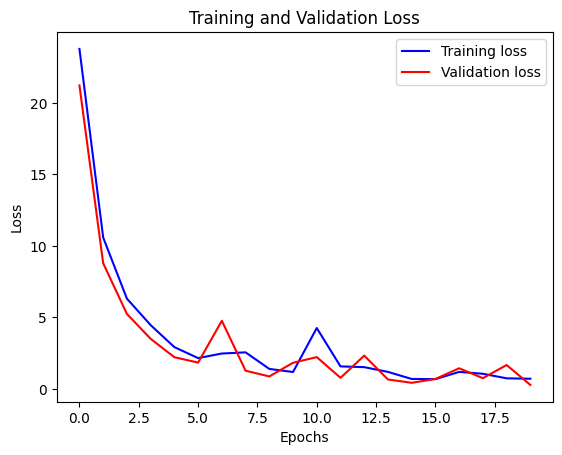

In [325]:
visualize_loss(history, "Training and Validation Loss")

In [ ]:
history = models['cnn'].fit(train_gen, epochs=15, validation_data=val_gen)

Epoch 1/15
32/32 [==============================] - 15s 430ms/step - loss: 42.0030 - root_mean_squared_error: 6.4810 - mean_absolute_error: 4.6006 - val_loss: 54.4210 - val_root_mean_squared_error: 7.3771 - val_mean_absolute_error: 5.9755
Epoch 2/15
32/32 [==============================] - 12s 368ms/step - loss: 33.6020 - root_mean_squared_error: 5.7967 - mean_absolute_error: 4.2480 - val_loss: 47.0502 - val_root_mean_squared_error: 6.8593 - val_mean_absolute_error: 5.5362
Epoch 3/15
32/32 [==============================] - 12s 363ms/step - loss: 34.2241 - root_mean_squared_error: 5.8501 - mean_absolute_error: 4.3028 - val_loss: 43.6738 - val_root_mean_squared_error: 6.6086 - val_mean_absolute_error: 5.3320
Epoch 4/15
32/32 [==============================] - 12s 385ms/step - loss: 33.7291 - root_mean_squared_error: 5.8077 - mean_absolute_error: 4.2807 - val_loss: 47.9745 - val_root_mean_squared_error: 6.9264 - val_mean_absolute_error: 5.6044
Epoch 5/15
32/32 [==========================

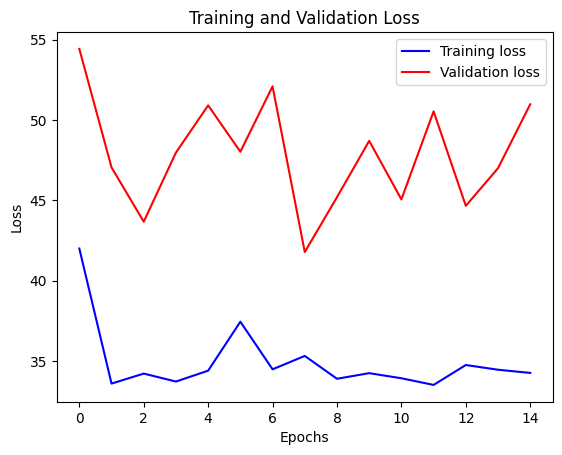

In [ ]:
visualize_loss(history, "Training and Validation Loss")

In [278]:
history = models['dnn'].fit(train_gen, epochs=15, validation_data=val_gen)

Epoch 1/15
32/32 [==============================] - 14s 381ms/step - loss: 38.4874 - root_mean_squared_error: 6.2038 - mean_absolute_error: 4.5147 - val_loss: 53.8610 - val_root_mean_squared_error: 7.3390 - val_mean_absolute_error: 5.9612
Epoch 2/15
32/32 [==============================] - 12s 369ms/step - loss: 36.2713 - root_mean_squared_error: 6.0226 - mean_absolute_error: 4.3860 - val_loss: 47.2913 - val_root_mean_squared_error: 6.8769 - val_mean_absolute_error: 5.5468
Epoch 3/15
32/32 [==============================] - 13s 408ms/step - loss: 35.1693 - root_mean_squared_error: 5.9304 - mean_absolute_error: 4.3196 - val_loss: 44.6588 - val_root_mean_squared_error: 6.6827 - val_mean_absolute_error: 5.3818
Epoch 4/15
32/32 [==============================] - 13s 402ms/step - loss: 35.5123 - root_mean_squared_error: 5.9592 - mean_absolute_error: 4.3506 - val_loss: 47.9549 - val_root_mean_squared_error: 6.9249 - val_mean_absolute_error: 5.5892
Epoch 5/15
32/32 [==========================

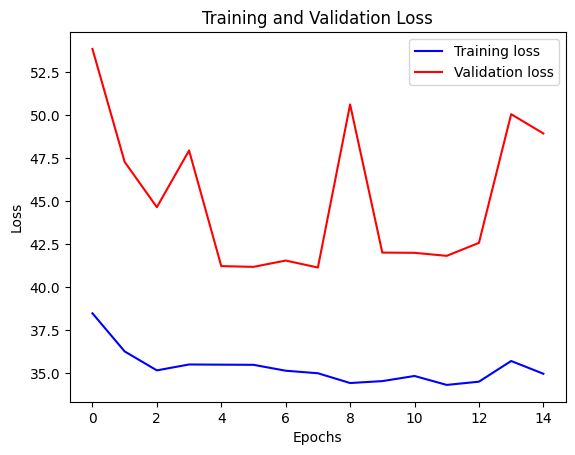

In [279]:
visualize_loss(history, "Training and Validation Loss")

In [326]:
t, u, y = dynamic_process.generate_time_series(10, 1000, new_inputs=True)

In [ ]:
def create_full_prediction(t, u, y, model, window_size=15):
    y_pred = []
    u_extended = np.concatenate((np.zeros(window_size), u))
    y_window = np.zeros(window_size)
    for i in range(len(t)):
        
        input_for_pred = np.array([np.concatenate((u_extended[i:i+window_size], y_window))])
        y_hat = model.predict(input_for_pred)[0][0]
        y_pred.append(y_hat)
        
        y_window = np.roll(y_window, -1)
        y_window[window_size-1] = y_hat
        
    return y_pred

In [327]:
prediction = create_full_prediction(t, u, y, models['rnn'], window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 51ms/step


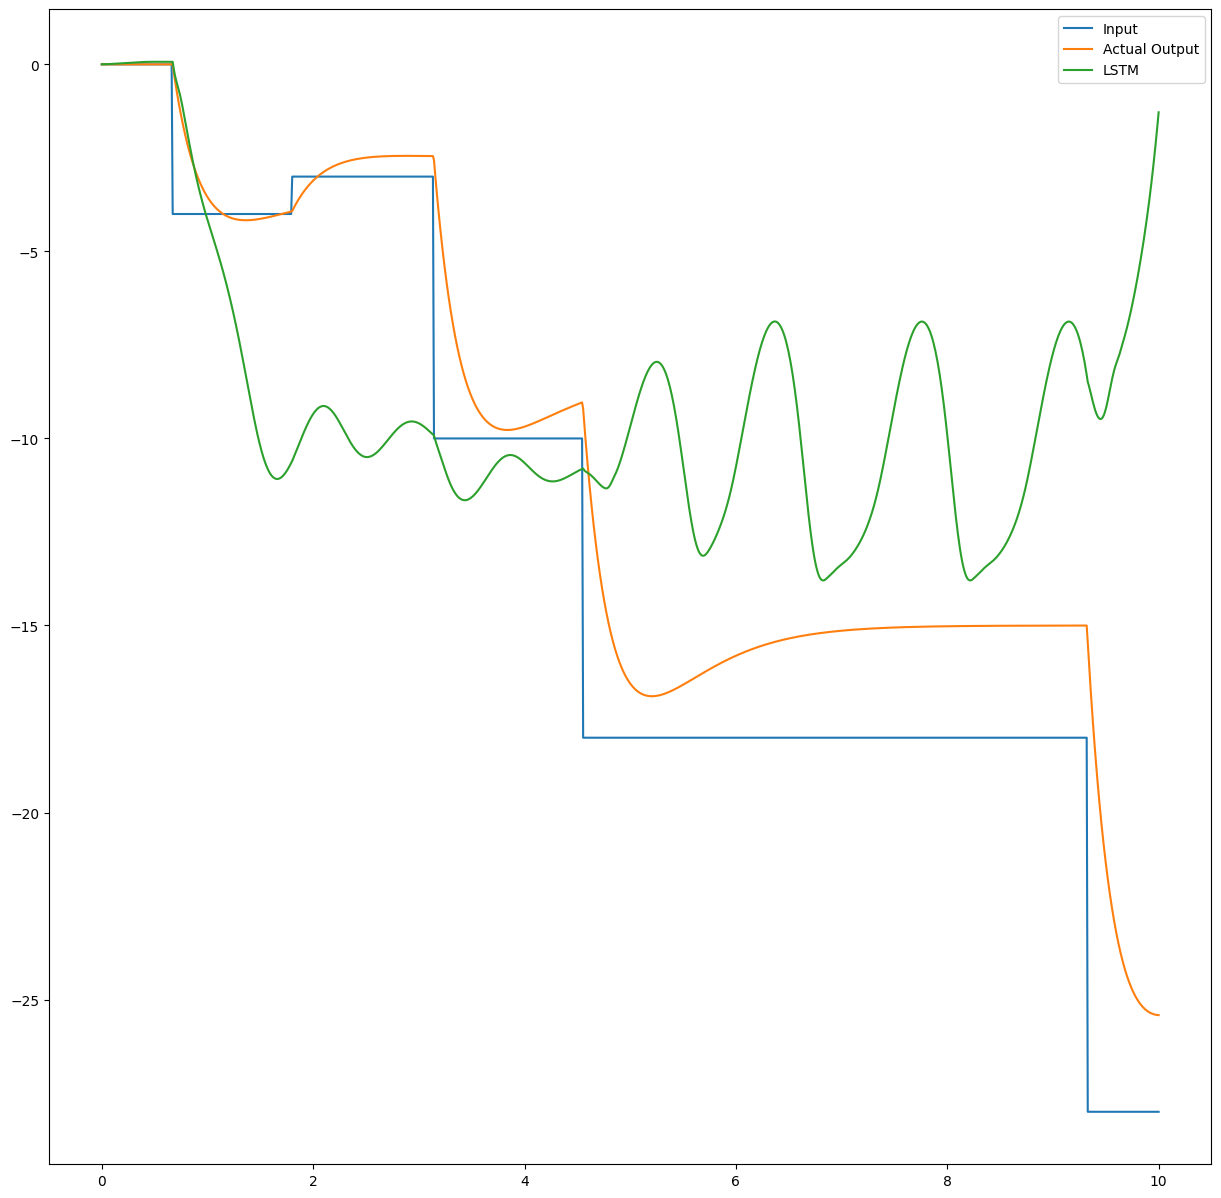

In [328]:
plt.figure(figsize=(15,15))
plt.plot(t, u)
plt.plot(t, y)
plt.plot(t, prediction)
plt.legend(['Input', 'Actual Output','LSTM'])
plt.show()

In [329]:
predictions = {}
for name, model in models.items():
    predictions[name] = create_full_prediction(t, u, y, model, window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 51ms/step


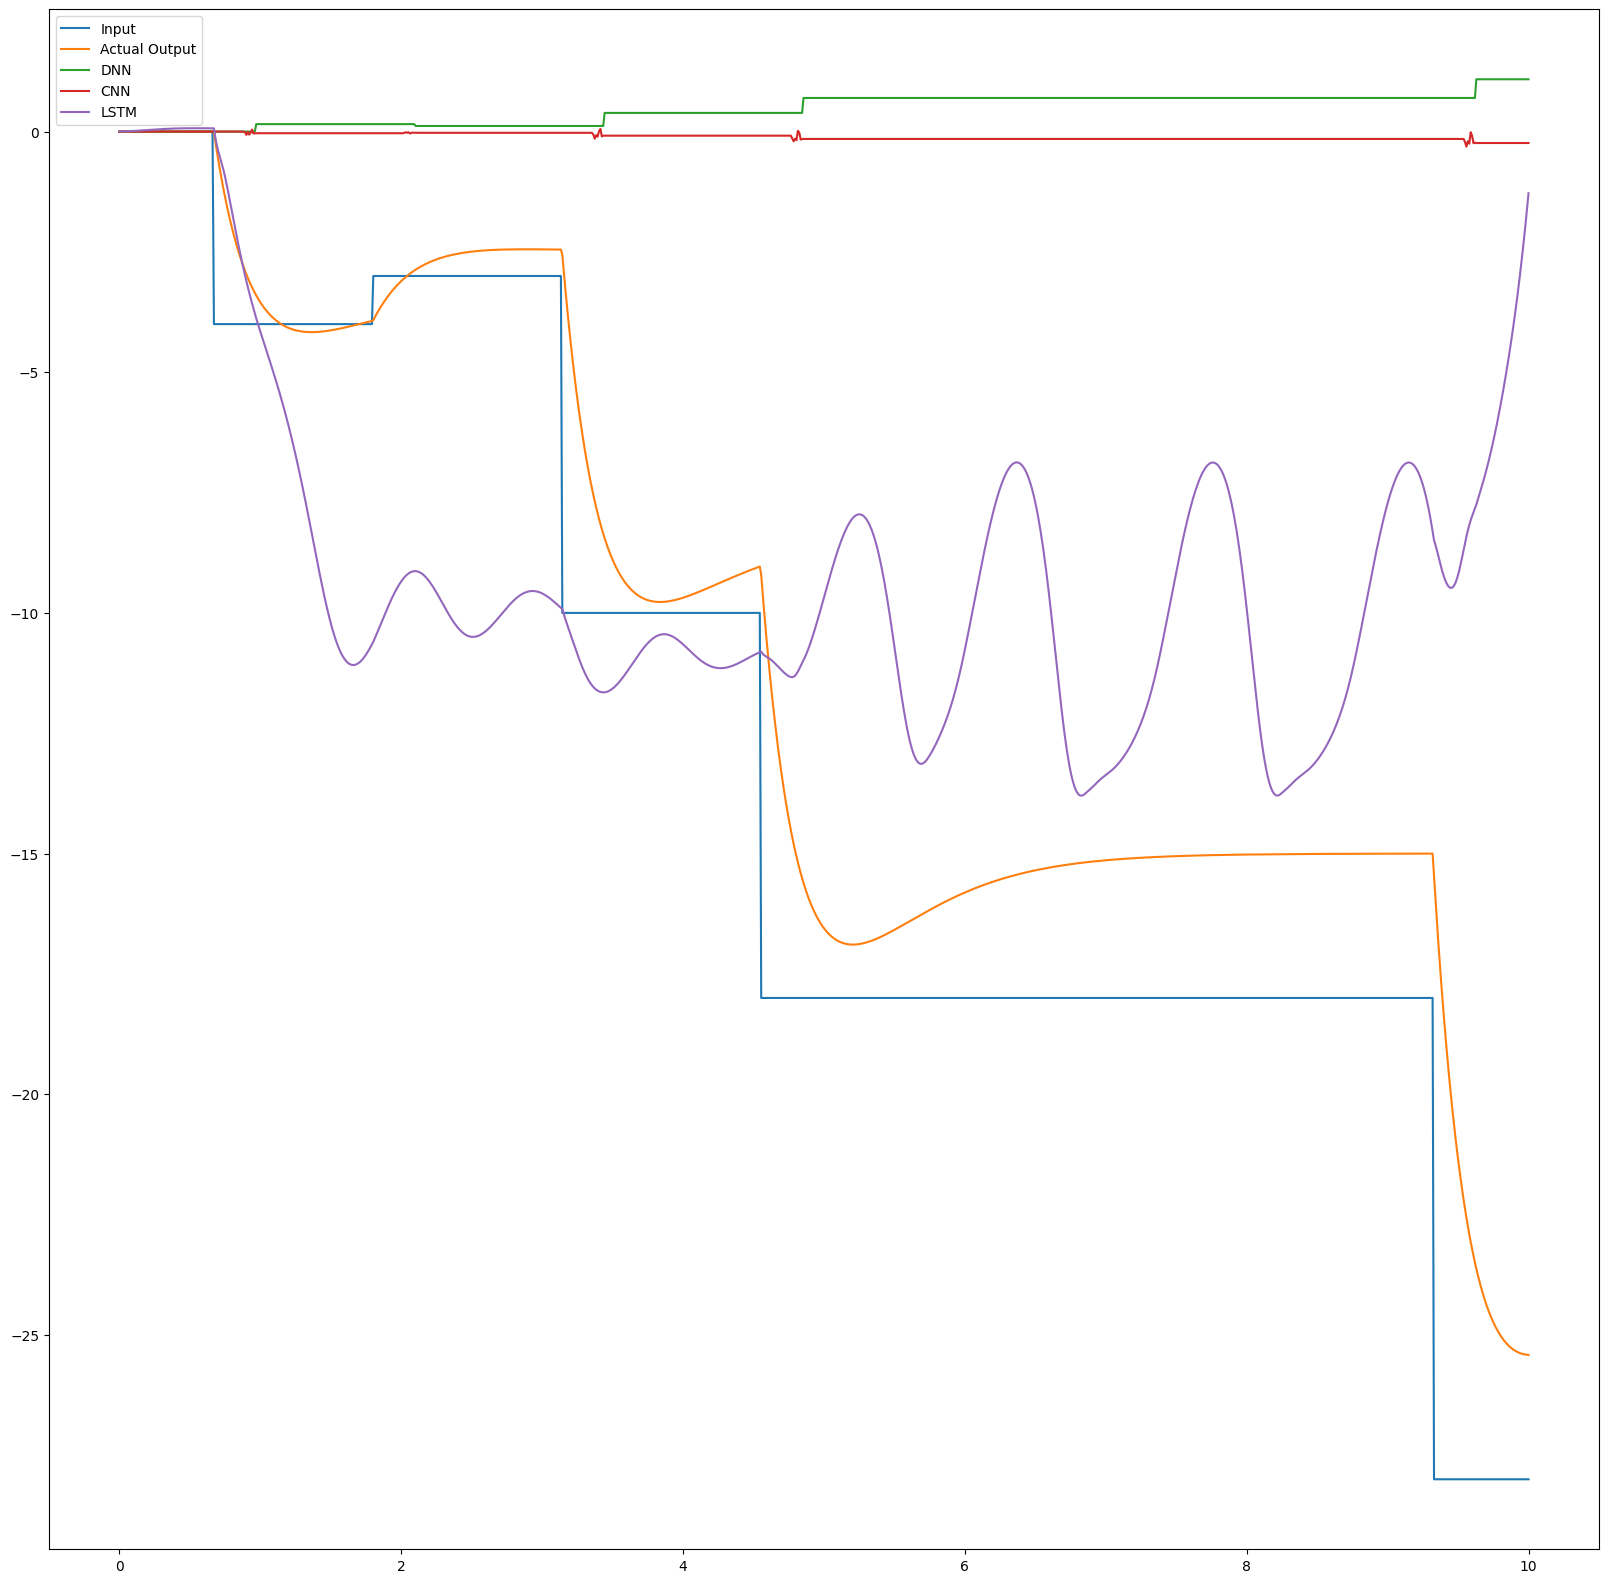

In [330]:
plt.figure(figsize=(20,20))
plt.plot(t, u)
plt.plot(t, y)

for name, prediction in predictions.items():
    # plt.subplot(3,1,i+1) ??
    plt.plot(t, prediction)
    
plt.legend(['Input', 'Actual Output', 'DNN', 'CNN', 'LSTM'])
plt.show()

In [245]:
name = 'rnn'
models[name].save(f'models/{name}')

INFO:tensorflow:Assets written to: models/rnn/assets


INFO:tensorflow:Assets written to: models/rnn/assets


In [290]:
name = 'cnn'
models[name].save(f'models/{name}')

INFO:tensorflow:Assets written to: models/cnn/assets


INFO:tensorflow:Assets written to: models/cnn/assets


In [291]:
name = 'dnn'
models[name].save(f'models/{name}')

INFO:tensorflow:Assets written to: models/dnn/assets


INFO:tensorflow:Assets written to: models/dnn/assets
